<a href="https://colab.research.google.com/github/grovermayank/facial_expressions/blob/master/FauxNewsSensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 33kB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 450kB 42.9MB/s 
     |████████████████████████████████| 3.8MB 35.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=071952ec00f702ea11634375bd6366fbc7c7c3144c809d59d44bee61980248c7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installa

In [4]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy # For Advanced Natural Language Processing
!pip install WordCloud
!pip install gensim # For Unsupervised Topic Modeling And Natural Language Processing

Requirement already up-to-date: nbformat in /usr/local/lib/python3.7/dist-packages (5.1.3)


In [2]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
df_true = pd.read_csv("https://raw.githubusercontent.com/grovermayank/faux_news/main/True.csv")
df_fake = pd.read_csv("https://raw.githubusercontent.com/grovermayank/faux_news/main/Fake.csv")

In [8]:
df_true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [9]:
df_fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [12]:
df_true['isfake'] = 1
df_true.head()

,title,text,subject,date,istrue,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,1


In [11]:
df_fake['isfake'] = 0
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [13]:
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,title,text,subject,date,istrue,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1.0,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1.0,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1.0,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1.0,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1.0,1
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",NaN,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",NaN,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",NaN,0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",NaN,0


In [14]:
df.drop(columns = ['date'], inplace = True)

In [15]:
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,istrue,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1.0,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1.0,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1.0,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1.0,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1.0,1,Trump wants Postal Service to charge 'much mor...


In [16]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [17]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [20]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [21]:
df['clean'] = df['original'].apply(preprocess)

In [22]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [23]:
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [24]:
df

,title,text,subject,istrue,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1.0,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1.0,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1.0,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1.0,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1.0,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,NaN,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,NaN,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,NaN,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,NaN,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal..."


In [25]:
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [26]:
list_of_words


['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [27]:
len(list_of_words)

9277072

In [28]:
total_words = len(list(set(list_of_words)))
total_words

108705

In [30]:
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [31]:
df

,title,text,subject,istrue,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1.0,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1.0,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1.0,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1.0,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1.0,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,NaN,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,NaN,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,NaN,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,NaN,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


In [32]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

In [33]:
df

,title,text,subject,istrue,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1.0,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1.0,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1.0,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1.0,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1.0,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,NaN,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,NaN,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,NaN,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,NaN,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


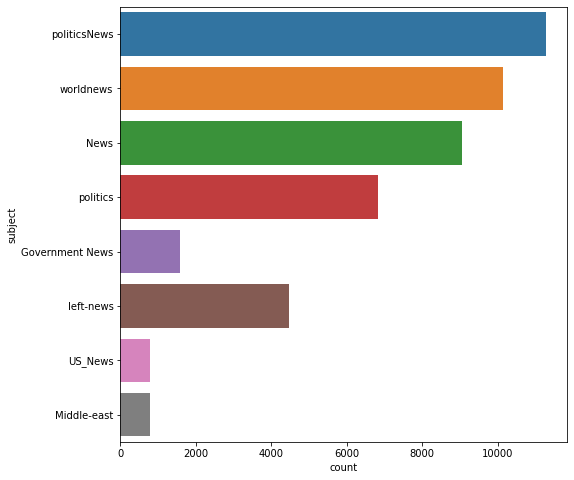

In [34]:
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)

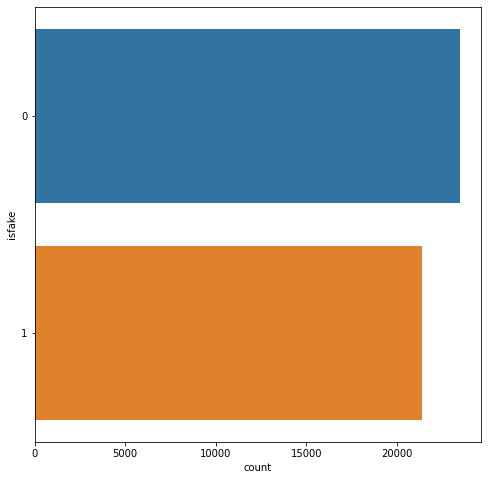

In [35]:
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

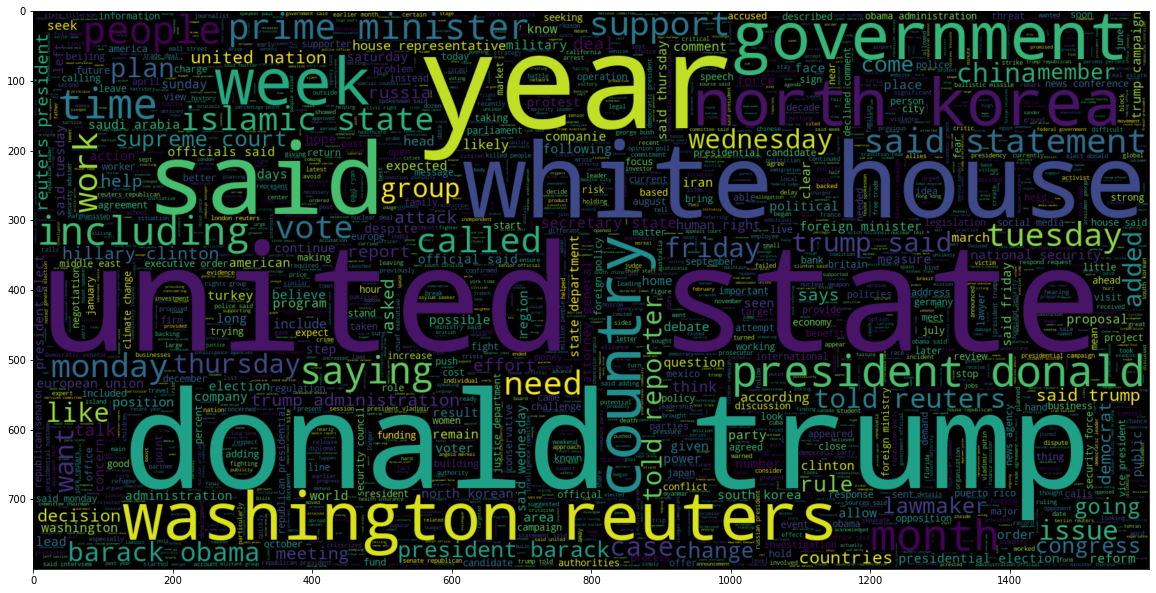

In [36]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

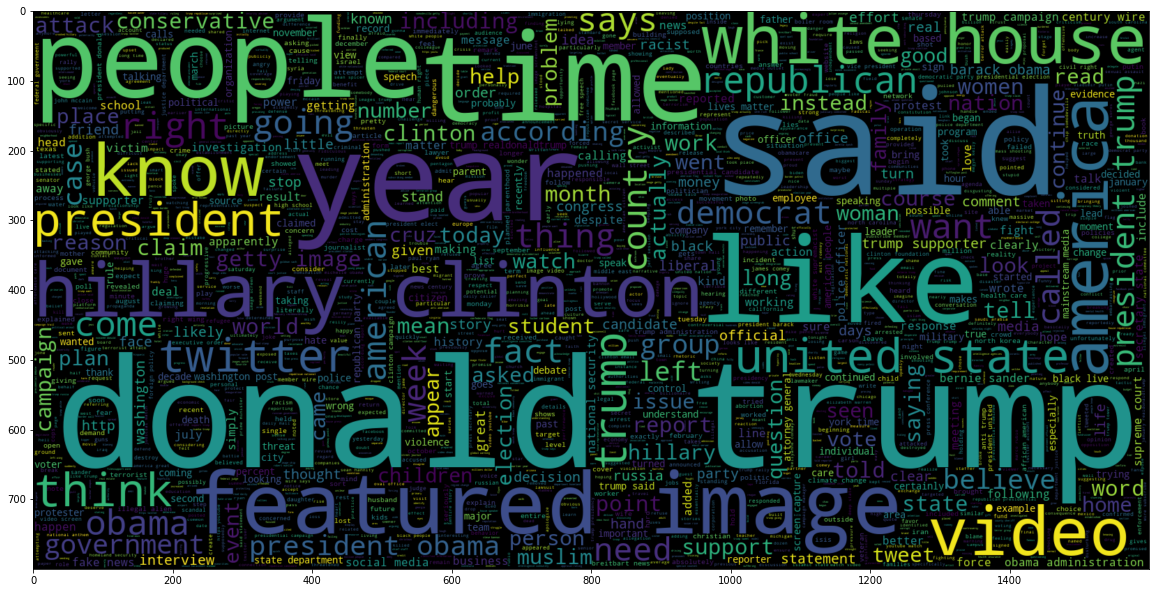

In [37]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [38]:
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4406


In [39]:
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()


In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [41]:
from nltk import word_tokenize

In [42]:
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [43]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [44]:
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post')

In [45]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [ 1143  2010  2048   525   639  1726    20 65446   531     3   445  3634
  1457   100 15731 11469  4902  2150  1600  5953  1958  5091  8697   753
   334  5091 14768  1316    40    50  3061  3025   531  6472   525  2101
   159   193   544    21]
The padded encoding for document 2  is :  [  557  1896     1  3691   330  4336    99   430   346   398   517   304
    47  2901    10     1  2773   204   224   402 14541  1831   391   616
    19   933  3011   642   350  2226     1   625  1072   330  4351  5596
   430   320  2070   886]


In [46]:
model = Sequential()

# Embeddidng layer
model.add(Embedding(total_words, output_dim = 128))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         13914240  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,210,433
Trainable params: 14,210,433
Non-trainable params: 0
_________________________________________________________________


In [47]:
total_words

108705

In [48]:
y_train = np.asarray(y_train)

In [49]:
pred = model.predict(padded_test)

In [50]:
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

In [51]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.5187082405345211


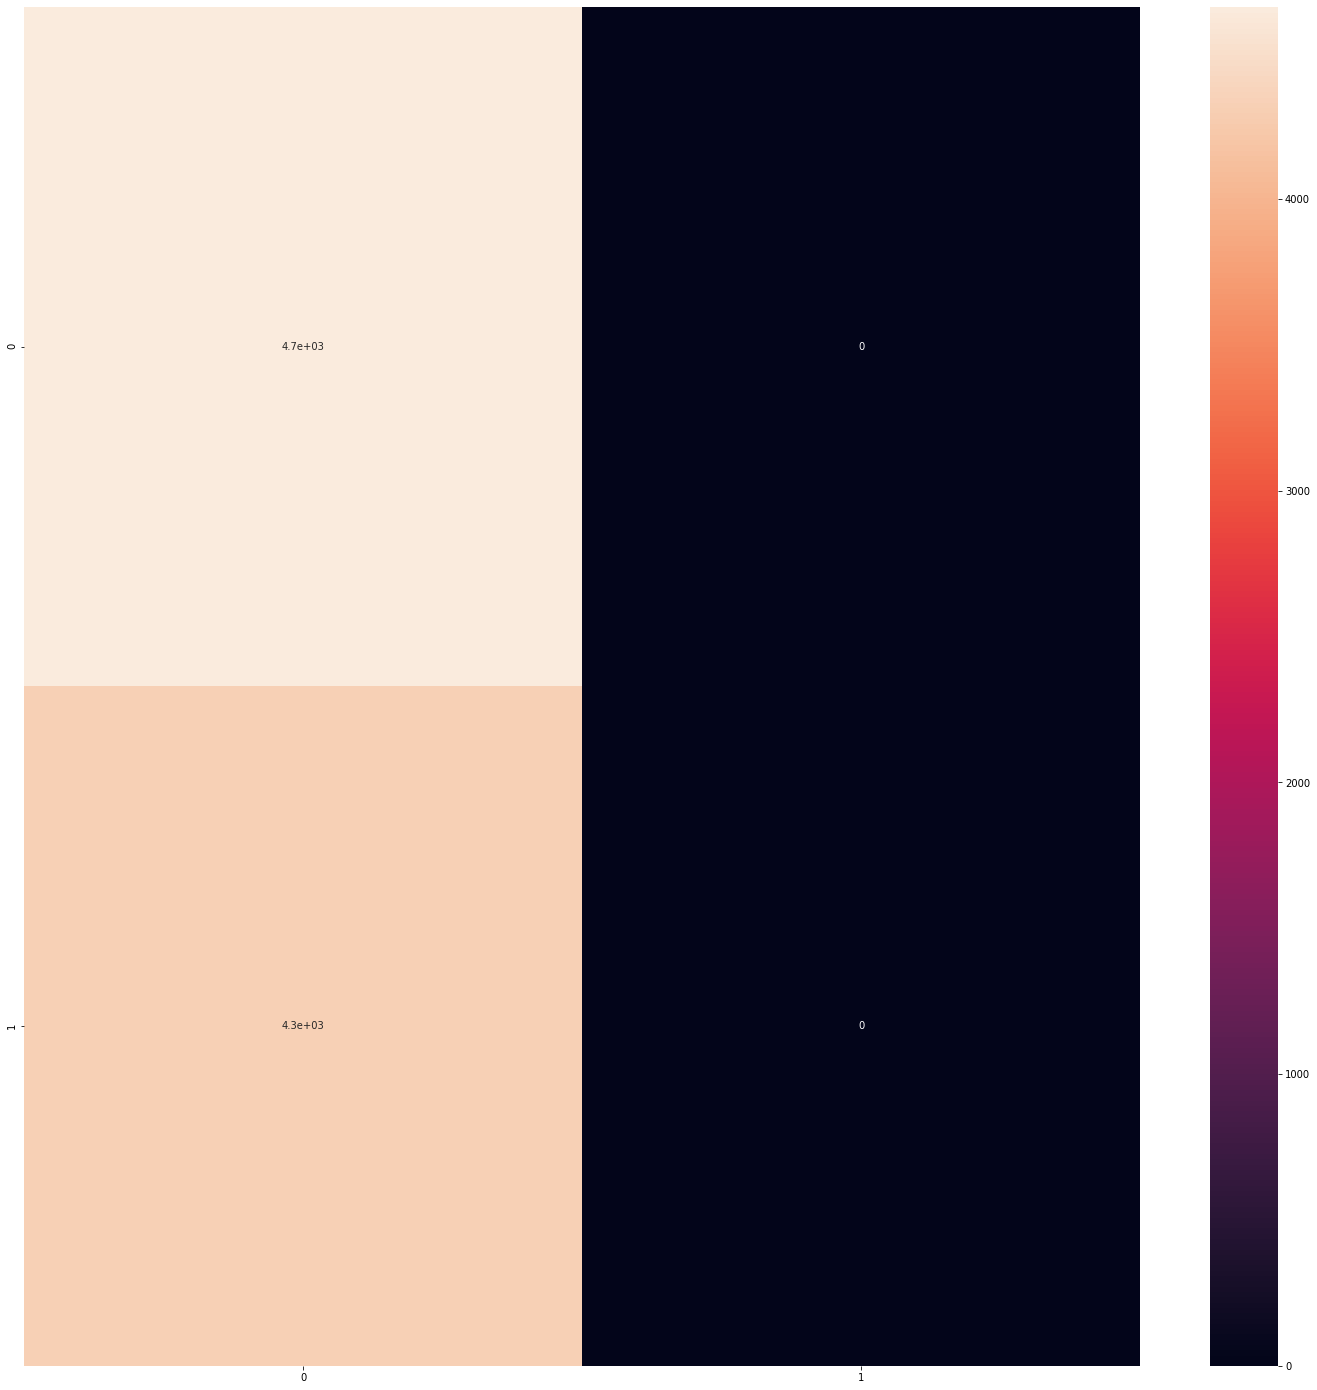

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)